In [1]:
from argparse import ArgumentParser
import os
import sys
import random
import logging
import matplotlib.pyplot as plt
import numpy as np

from scipy import integrate
from sklearn.metrics import mean_squared_error as MSE
import copy

from tqdm.auto import tqdm, trange
from tqdm.contrib import tenumerate

import torch
from torch.utils.data import DataLoader

In [2]:
from IPython.display import SVG, display
import plotly.graph_objects as go
import plotly.express as px

%matplotlib inline 
%config InlineBackend.figure_format='retina'
%load_ext autoreload 
%autoreload 2

def imshow(fig):
    return display(SVG(fig.to_image(format="svg")))

In [3]:
sys.path.append("/tmp/pycharm_project_660/src")
from plotter import *
from model import DeepSTPP, log_ft, t_intensity, s_intensity
from data.dataset import SlidingWindowWrapper
from data.adapter import DataAdapter
from data.synthetic import *

/tmp/pycharm_project_660/src/plotter.py:94: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cmax is "outlier":
/tmp/pycharm_project_660/src/plotter.py:155: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if cmax is "outlier":
/tmp/pycharm_project_660/src/model.py:271: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.config.constrain_b is 'tanh':
/tmp/pycharm_project_660/src/model.py:273: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.config.constrain_b is 'sigmoid':
/tmp/pycharm_project_660/src/model.py:275: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.config.constrain_b is 'neg-sigmoid':
/tmp/pycharm_project_660/src/model.py:277: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.config.constrain_b is 'softplus':
/tmp/pycharm_project_660/src/model.py:279: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif self.config.constrain_b is 'clamp':


In [4]:
"""The code below is used to set up customized training device on computer"""
if torch.cuda.is_available():
    device = torch.device('cuda:0')
    print("You are using GPU acceleration.")
    print("Device name: ", torch.cuda.get_device_name(0))
    print("Number of CUDAs(cores): ", torch.cuda.device_count())
else:
    device = torch.device("cpu")
    print("CUDA is not Available. You are using CPU only.")
    print("Number of cores: ", os.cpu_count())

You are using GPU acceleration.
Device name:  NVIDIA GeForce RTX 2080 Ti
Number of CUDAs(cores):  8


In [5]:
class AverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [6]:
def visualize_diff(outputs, targets, portion=1):
    outputs = outputs[:int(len(outputs) * portion)]
    targets = targets[:int(len(targets) * portion)]

    plt.figure(figsize=(14, 10), dpi=180)
    plt.subplot(2, 2, 1)

    n = outputs.shape[0]
    lookahead = outputs.shape[1]

    for i in range(lookahead):
        plt.plot(range(i, n), outputs[:n - i, i, 0], "-o", label=f"Predicted {i} step")
    plt.plot(targets[:, 0, 0], "-o", color="b", label="Actual")
    plt.ylabel('Latitude')
    plt.legend()

    plt.subplot(2, 2, 2)
    for i in range(lookahead):
        plt.plot(range(i, n), outputs[:n - i, i, 1], "-o", label=f"Predicted {i} step")
    plt.plot(targets[:, 0, 1], "-o", color="b", label="Actual")
    plt.ylabel('Longitude')
    plt.legend()

    plt.subplot(2, 2, 3)
    for i in range(lookahead):
        plt.plot(range(i, n), outputs[:n - i, i, 2], "-o", label=f"Predicted {i} step")
    plt.plot(targets[:, 0, 2], "-o", color="b", label="Actual")
    plt.ylabel('delta_t (hours)')
    plt.legend()
    plt.savefig('result.png')

In [7]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

config = Namespace(hid_dim=128, emb_dim=128, out_dim=0, n_layers=1,
                   lr=0.0003, momentum=0.9, epochs=10, batch=128, opt='Adam', generate_type=True,
                   read_model=False, seq_len=20, eval_epoch=5, s_min=1e-3, b_max=20,
                   lookahead=1, alpha=0.1, z_dim=128, beta=1e-3, dropout=0, num_head=2,
                   nlayers=3, num_points=20, infer_nstep=10000, infer_limit=13, clip=1.0,
                   constrain_b='sigmoid', sample=True, decoder_n_layer=3)

In [8]:
"""
Prepare logger
"""
logger = logging.getLogger('full_lookahead{}batch{}'.format(config.lookahead, config.batch))
logger.setLevel(logging.DEBUG)
hdlr = logging.FileHandler('full_lookahead{}batch{}.log'.format(config.lookahead, config.batch))
formatter = logging.Formatter('%(asctime)s %(levelname)s %(message)s')
hdlr.setFormatter(formatter)
logger.addHandler(hdlr)

# create console handler with a higher log level
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
ch.setFormatter(formatter)
logger.addHandler(ch)

### Transformer-Encoder VAE (last output only)

In [9]:
def eval_loss(model, test_loader, device):
    model.eval()
    loss_total = 0
    sll_meter = AverageMeter()
    tll_meter = AverageMeter()
    loss_meter = AverageMeter()
    
    for index, data in enumerate(test_loader):
        st_x, st_y, _, _, _ = data
        loss, sll, tll = model.loss(st_x, st_y)
        
        loss_meter.update(loss.item())
        sll_meter.update(sll.mean())
        tll_meter.update(tll.mean())
        
    return loss_meter.avg, sll_meter.avg, tll_meter.avg

In [10]:
def train(model, train_loader, val_loader, config, logger, device):
    scheduler = torch.optim.lr_scheduler.StepLR(model.optimizer, step_size=50, gamma=0.2)
    best_eval = np.infty
    sll_meter = AverageMeter()
    tll_meter = AverageMeter()
    loss_meter = AverageMeter()
    
    for epoch in trange(config.epochs):
        loss_total = 0
        model.train()
        for index, data in tenumerate(train_loader):
            st_x, st_y, _, _, _ = data

            model.optimizer.zero_grad()
            loss, sll, tll = model.loss(st_x, st_y)
            loss.backward()
            model.optimizer.step()

            loss_meter.update(loss.item())
            sll_meter.update(sll.mean())
            tll_meter.update(tll.mean())

        scheduler.step()

        logger.info("In epochs {} | "
                    "total loss: {:5f} | Space: {:5f} | Time: {:5f}".format(
            epoch, loss_meter.avg, sll_meter.avg , tll_meter.avg
        ))
        if (epoch+1)%config.eval_epoch==0:
            print("Evaluate")
            valloss, valspace, valtime = eval_loss(model, val_loader, device)
            logger.info("Val Loss {:5f} | Space: {:5f} | Time: {:5f}".format(valloss, valspace, valtime))
            if valloss < best_eval:
                best_eval = valloss
                best_model = copy.deepcopy(model)

    print("training done!")
    return best_model

In [11]:
def visualize_diff(outputs, targets, portion=1):
    outputs = outputs[:int(len(outputs) * portion)]
    targets = targets[:int(len(targets) * portion)]

    plt.figure(figsize=(14, 10), dpi=180)
    plt.subplot(2, 2, 1)

    n = outputs.shape[0]
    lookahead = 1

    for i in range(lookahead):
        plt.plot(range(i, n), outputs[:n - i, i, 0], "-o", label=f"Predicted {i} step")
    plt.plot(targets[:, 0, 0], "-o", color="b", label="Actual")
    plt.ylabel('Latitude')
    plt.legend()

    plt.subplot(2, 2, 2)
    for i in range(lookahead):
        plt.plot(range(i, n), outputs[:n - i, i, 1], "-o", label=f"Predicted {i} step")
    plt.plot(targets[:, 0, 1], "-o", color="b", label="Actual")
    plt.ylabel('Longitude')
    plt.legend()

    plt.subplot(2, 2, 3)
    for i in range(lookahead):
        plt.plot(range(i, n), outputs[:n - i, i, 2], "-o", label=f"Predicted {i} step")
    plt.plot(targets[:, 0, 2], "-o", color="b", label="Actual")
    plt.ylabel('delta_t (hours)')
    plt.legend()
    plt.savefig('result.png')

## Training

In [12]:
npzf = np.load('/tmp/pycharm_project_660/data/processed/covid_nj_cases.npz', allow_pickle=True)

In [13]:
trainset = SlidingWindowWrapper(npzf['train'], normalized=True)
valset   = SlidingWindowWrapper(npzf['val'],   normalized=True, min=trainset.min, max=trainset.max)
testset  = SlidingWindowWrapper(npzf['test'],  normalized=True, min=trainset.min, max=trainset.max)

In [14]:
train_loader = DataLoader(trainset, batch_size=config.batch, shuffle=True)
val_loader   = DataLoader(valset,   batch_size=config.batch, shuffle=False)
test_loader  = DataLoader(testset,  batch_size=config.batch, shuffle=False)

In [15]:
model = DeepSTPP(config, device)
best_model = train(model, train_loader, val_loader, config, logger, device)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/901 [00:00<?, ?it/s]

2022-06-07 21:17:29,334 INFO In epochs 0 | total loss: 0.225975 | Space: 0.864564 | Time: 3.634475


  0%|          | 0/901 [00:00<?, ?it/s]

2022-06-07 21:17:54,122 INFO In epochs 1 | total loss: 0.110641 | Space: 1.039313 | Time: 3.661157


  0%|          | 0/901 [00:00<?, ?it/s]

2022-06-07 21:18:15,008 INFO In epochs 2 | total loss: 0.072145 | Space: 1.102536 | Time: 3.669554


  0%|          | 0/901 [00:00<?, ?it/s]

2022-06-07 21:18:35,715 INFO In epochs 3 | total loss: 0.052901 | Space: 1.135465 | Time: 3.673627


  0%|          | 0/901 [00:00<?, ?it/s]

2022-06-07 21:18:56,450 INFO In epochs 4 | total loss: 0.041370 | Space: 1.155838 | Time: 3.676198


Evaluate


2022-06-07 21:18:56,655 INFO Val Loss -0.003766 | Space: 1.164886 | Time: 2.699660


  0%|          | 0/901 [00:00<?, ?it/s]

2022-06-07 21:19:17,323 INFO In epochs 5 | total loss: 0.033695 | Space: 1.169710 | Time: 3.677838


  0%|          | 0/901 [00:00<?, ?it/s]

2022-06-07 21:19:37,924 INFO In epochs 6 | total loss: 0.028217 | Space: 1.179807 | Time: 3.679050


  0%|          | 0/901 [00:00<?, ?it/s]

2022-06-07 21:19:59,992 INFO In epochs 7 | total loss: 0.024109 | Space: 1.187481 | Time: 3.680027


  0%|          | 0/901 [00:00<?, ?it/s]

2022-06-07 21:20:21,937 INFO In epochs 8 | total loss: 0.020912 | Space: 1.193591 | Time: 3.680744


  0%|          | 0/901 [00:00<?, ?it/s]

2022-06-07 21:20:43,064 INFO In epochs 9 | total loss: 0.018355 | Space: 1.198495 | Time: 3.681347


Evaluate


2022-06-07 21:20:43,328 INFO Val Loss -0.003714 | Space: 1.173882 | Time: 2.691295


training done!


In [ ]:
torch.save(best_model.state_dict(), 'covid_nj_cases.mod')

## Evaluation

Intensity time range : 7.0


  0%|          | 0/200 [00:00<?, ?it/s]

Inferred cmax: 187.1622772216797


  0%|          | 0/202 [00:00<?, ?it/s]

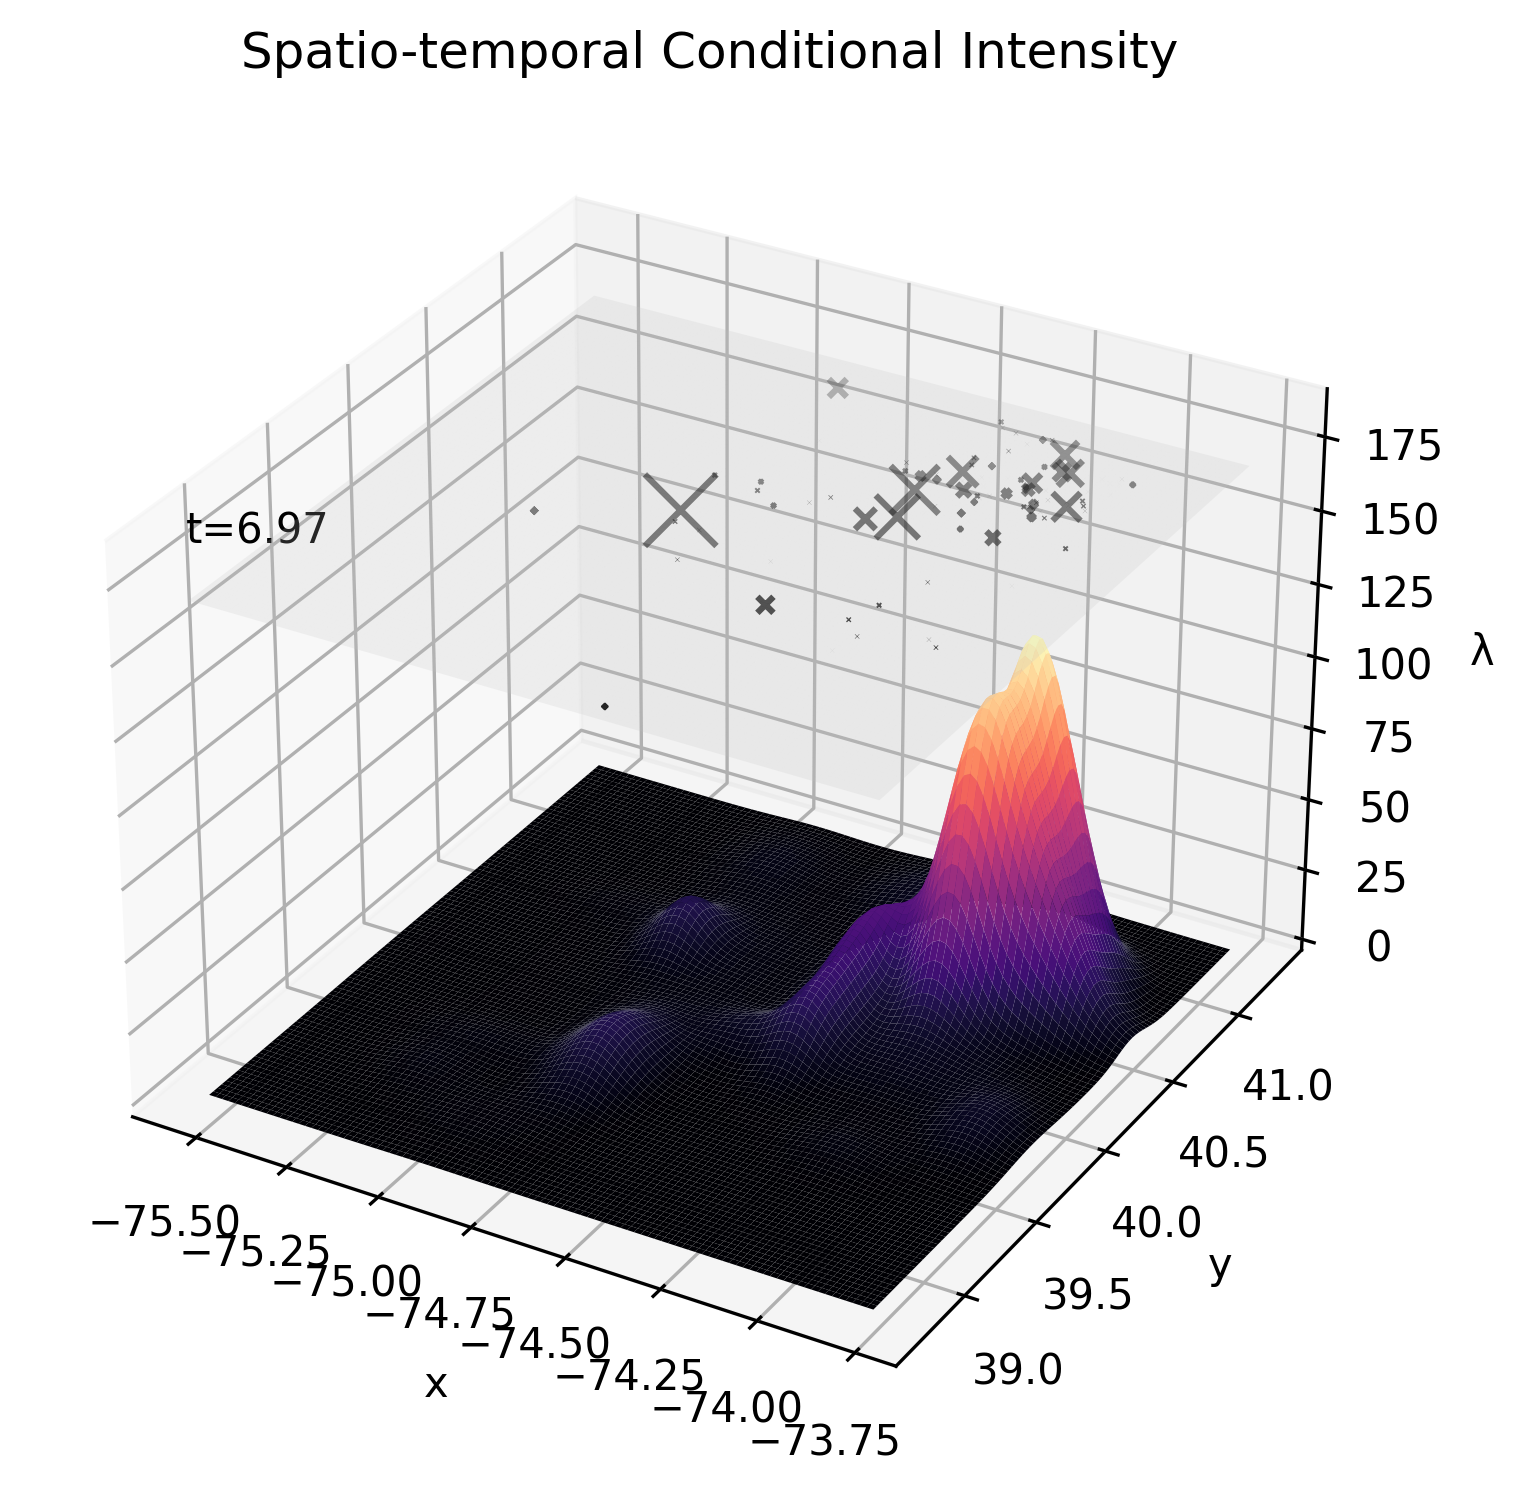

In [18]:
from model import calc_lamb

scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
lambs, x_range, y_range, t_range, his_s, his_t = calc_lamb(model, test_loader, config, device, scales, biases, total_time=7.0, round_time=False)
plot_lambst_static(lambs, x_range, y_range, t_range, history=(his_s, his_t), decay=10,
                   scaler=None, fps=12, fn=f'/tmp/pycharm_project_660/temp.mp4')

In [25]:
def evaluate(model, st_scaler, test_loader, logger, device):
    model.eval()
    st_preds = []
    st_ys = []
    lookahead = config.lookahead

    for index, data in enumerate(test_loader):
        if len(data) == 6:
            st_x, _, _, st_y, _, _ = data
        else:
            st_x, st_y = data

        batch_size = st_x.shape[0]
        st_pred = torch.zeros((batch_size, lookahead, 3), dtype=torch.float).to(device)
        background = model.background.unsqueeze(0).repeat(batch_size, 1, 1).cpu().detach()
        
        for l in range(lookahead):
            _, w_i, b_i, _ = model(st_x.to(device))
            w_i  = w_i.cpu().detach()
            b_i  = b_i.cpu().detach()
            
            st_pred_1step = np.zeros((batch_size, 1, 3))
            
            t_cum = torch.cumsum(st_x[..., 2], -1)
            tn_ti = t_cum[..., -1:] - t_cum # t_n - t_i
            tn_ti = torch.cat((tn_ti, torch.zeros(batch_size, config.num_points)), -1)
            
            # Time inference: integrate via linear interpolation
            limit = config.infer_limit * st_scaler.scale_[-1]
            ts = torch.arange(0, limit, limit * 1.0 / config.infer_nstep)
            fts = [torch.exp(log_ft(t + tn_ti, tn_ti, w_i, b_i)) for t in ts]
            fts = torch.stack(fts) / sum(fts, 0) # normalize probability 
            predict_t = torch.sum(ts.unsqueeze(-1) * fts, 0) # expectation
            st_pred_1step[:, 0, 2] = predict_t.numpy()
            
            # Space Inference            
            v_i = w_i * torch.exp(-b_i * (tn_ti + predict_t.unsqueeze(-1)))
            v_i = v_i / torch.sum(v_i, -1).unsqueeze(-1) # normalize
            v_i = v_i.unsqueeze(-1).numpy()
            
            space = torch.cat((st_x[..., :2], background), 1)
            st_pred_1step[:, 0, :2] = np.sum(v_i * space.cpu().detach().numpy(), 1)
            
            st_pred_1step = torch.tensor(st_pred_1step, dtype=torch.float)
            st_pred[:, l, :] = st_pred_1step[:, 0, :]
            st_x = torch.cat((st_x[:, 1:], st_pred_1step ), 1)

        st_preds.append(st_pred)
        st_ys.append(st_y)

    st_preds = torch.cat(st_preds, dim=0).cpu().detach().numpy()
    st_y = torch.cat(st_ys, dim=0).cpu().detach().numpy()
    outputs = np.zeros(st_y.shape)
    targets = np.zeros(st_y.shape)
    
    for i in range(st_y.shape[0]):
        outputs[i] = st_scaler.inverse_transform(st_preds[i])
        targets[i] = st_scaler.inverse_transform(st_y[i])

    # Evaluate the performance using RMSE
    space_rmse = [np.mean([np.sqrt(MSE(outputs[:, i, :2], targets[:, i, :2])) for i in range(la)]) for la in
                  [1, ]] #[1, 5, 10, 20, 40]]
    time_rmse = [np.mean([np.sqrt(MSE(outputs[:, i, 2], targets[:, i, 2])) for i in range(la)]) for la in
                 [1, ]] #[1, 5, 10, 20, 40]]
    total_rmse = [np.mean([np.sqrt(MSE(outputs[:, i, :], targets[:, i, :])) for i in range(la)]) for la in
                  [1, ]] #[1, 5, 10, 20, 40]]

    logger.info(f"The RMSE for space is {space_rmse}")
    logger.info(f"The RMSE for time is {time_rmse}")
    logger.info(f"The 3-tuple RMSE  is {total_rmse}")

    return outputs, targets, [space_rmse, time_rmse, total_rmse]

In [33]:
def calc_lamb(model, st_scaler, test_loader, logger, device, 
              t_nstep=201, x_nstep=101, y_nstep=101):
    
    # Aggregate data
    st_xs = []
    st_ys = []
    for data in test_loader:
        if len(data) == 6:
            st_x, _, _, st_y, _, _ = data
        else:
            st_x, st_y = data
        st_xs.append(st_x)
        st_ys.append(st_y)
        
    st_x = torch.cat(st_xs, 0)
    st_y = torch.cat(st_ys, 0)
    total_time = torch.sum(st_y[:, 0, -1])
    
    print(f'Intensity time range : {total_time / st_scaler.scale_[-1]}', file=sys.stderr)
    lambs = []
    
    # Discretize space
    x_step = 1.0 / (x_nstep - 1)
    y_step = 1.0 / (y_nstep - 1)
    x_range = torch.arange(0, 1.0 + x_step, x_step)
    y_range = torch.arange(0, 1.0 + y_step, y_step)
    s_grids = torch.stack(torch.meshgrid(x_range, y_range), dim=-1).view(-1, 2)
    
    # Discretize time
    t_step = total_time * 1.0 / (t_nstep - 1)
    t_range = torch.arange(0, total_time, t_step)  
        
    # Calculate intensity
    batch_size = st_x.shape[0]
    background = model.background.unsqueeze(0).cpu().detach()

    # Sample model parameters
    _, w_i, b_i, inv_var = model(st_x.to(device))
    w_i  = w_i.cpu().detach()
    b_i  = b_i.cpu().detach()
    inv_var = inv_var.cpu().detach()

    t_y = st_y[:, 0, -1] # target time
    t_y_cum = torch.cumsum(t_y, 0) # cumulative target time

    for t in tqdm(t_range):
        i = sum(t_y_cum + 1e-5 < t) # index of corresponding history events
        t_ = t - t_y_cum[i-1] if i > 1 else t # time since lastest event

        st_x_ = st_x[i:i+1]
        w_i_ = w_i[i:i+1]
        b_i_ = b_i[i:i+1]
        inv_var_ = inv_var[i:i+1]

        # Calculate temporal intensity
        t_cum = torch.cumsum(st_x_[..., -1], -1)
        tn_ti = t_cum[..., -1:] - t_cum # t_n - t_i
        tn_ti = torch.cat((tn_ti, torch.zeros(1, config.num_points)), -1)
        t_ti  = tn_ti + t_

        lamb_t = t_intensity(w_i_, b_i_, t_ti)

        # Calculate spatial intensity
        N = len(s_grids) # number of grid points

        s_x_ = torch.cat((st_x_[..., :-1], background), 1).repeat(N, 1, 1)
        s_diff = s_grids.unsqueeze(1) - s_x_
        lamb_s = s_intensity(w_i_.repeat(N, 1), b_i_.repeat(N, 1), t_ti.repeat(N, 1), 
                             s_diff, inv_var_.repeat(N, 1, 1))

        lamb = (lamb_s * lamb_t).view(x_nstep, y_nstep)
        lambs.append(lamb.numpy())
            
    return lambs, x_range, y_range, t_range

In [53]:
from model import calc_lamb

In [34]:
scales = (trainset.max - trainset.min).cpu().numpy()
biases = trainset.min.cpu().numpy()
print(scales)
print(biases)

[1.7725601 2.5865707 4.8739667]
[-7.5547775e+01  3.8723499e+01  6.6536053e-08]


In [47]:
seqlens = [seq[2][-1] for seq in testset]

In [58]:
lambs

[array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]], dtype=float32),
 array([[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [n

In [57]:
from model import calc_lamb
lambs, x_range, y_range, t_range, his_s, his_t = calc_lamb(model, test_loader, config, device, scales, biases, total_time=30.0, round_time=False)
#plot_lambst_static(lambs, x_range, y_range, t_range, history=(his_s, his_t), decay=2,
#                   scaler=None, fps=12, fn=f'../video/temp.mp4')

Intensity time range : 30.0


  0%|          | 0/200 [00:00<?, ?it/s]

Intensity time range : 977.3203735351562
100%|██████████| 200/200 [01:28<00:00,  2.27it/s]


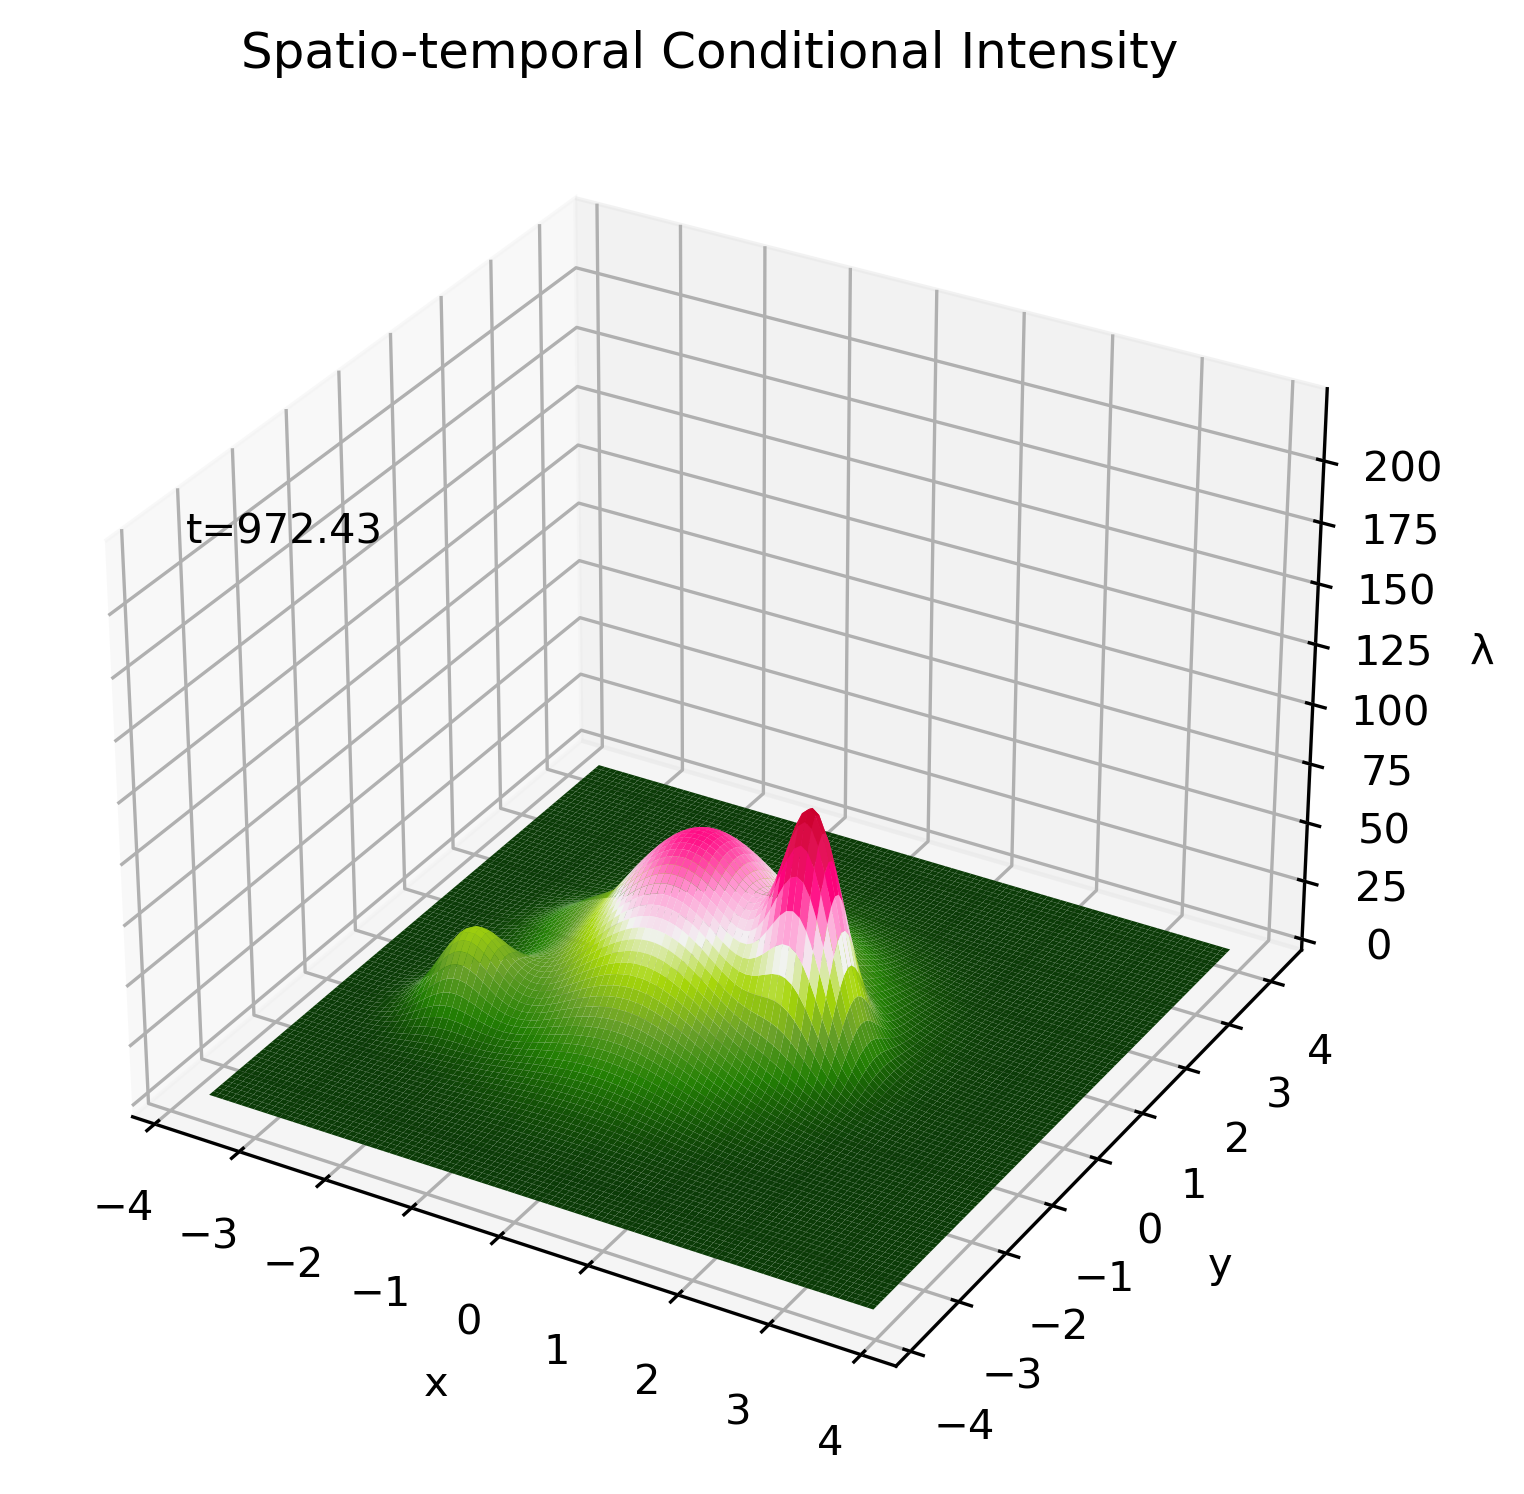

In [35]:
torch.save(best_model.state_dict(), 'model/sthp2.mod')
plot_lambst_static(*calc_lamb(best_model, da.st_scaler, test_loader, logger, device),
                   scaler=da.st_scaler, fps=12, fn='video/sthp2.mp4')